In [1]:
from utils import *

In [2]:
pool = Pool(4)

In [3]:
def get_cov(R,S,H):
    Z = np.zeros(len(R))
    return np.array([[R,Z,Z,H],
                     [Z,R,-H,Z],
                     [Z,-H,S,Z],
                     [H,Z,Z,S]])

def get_RSH(A,B,g0,b,ka):
    bigO=A + 2*B/ka**2/g0
    
    op2 = 1/2 * (bigO+abs(bigO)*np.sqrt(1+8*B/g0/bigO**2))
    om2 = 1/2 * (bigO-abs(bigO)*np.sqrt(1+8*B/g0/bigO**2))
    
    o02 = op2
    mu = ka
    S = 1/2/g0/ka**2*(ka**2+o02+g0*ka+b**2)
    R = 1/2/g0/o02/ka**2 * (o02+ka**2)
    H = - 1/2/g0/ka**2*b
    
    return R,S,H,o02, 2*(R*S+H**2)

def mean_with_err(arr, axis):
    return arr.mean(axis=axis), arr.std(axis=axis)/np.sqrt(arr.shape[axis])

In [4]:
# params - A,B,C,D,F,g0,b,ka

params = [
]

As = np.arange(-6,3.1,0.25)
params += [dict(A=A,B=0.05,g0=0.3,b=1,ka=1) for A in As]


df = pd.DataFrame(params, columns=["A","B","g0","b","ka"])

In [5]:
def f(row):
    op2, om2 = omega_kumulant(row.A,row.B,row.g0,row.ka)
    return pd.Series(get_RSH_harmonic_onlyka(np.sqrt(op2), row.g0, row.b, row.ka)+(op2,),
                     index=("R","S","H","varL", "o02"))
df = pd.concat([df, df.apply(f, axis=1)], axis=1, sort=False)

df["S_init"] = df.S

df["R_init"] = df.R

df["H_init"] = df.H

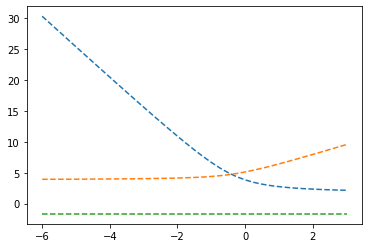

In [8]:
for i,lbl in enumerate(["R","S","H"]):
    plt.plot(df.A, df[lbl],"--",label=f"{lbl} theory", c=COLORS[i])


In [9]:
df["S_init"] = 0
df["R_init"] = 0
df["H_init"] = 0

In [10]:
df.head()

,A,B,g0,b,ka,R,S,H,varL,o02,S_init,R_init,H_init
0,-6.00,0.05,0.3,1,1,30.291126,3.930375,-1.666667,243.666553,0.058225,0,0,0
1,-5.75,0.05,0.3,1,1,29.054274,3.934758,-1.666667,234.198626,0.060855,0,0,0
2,-5.50,0.05,0.3,1,1,27.818650,3.939550,-1.666667,224.741485,0.063730,0,0,0
3,-5.25,0.05,0.3,1,1,26.584433,3.944811,-1.666667,215.296693,0.066887,0,0,0
4,-5.00,0.05,0.3,1,1,25.351838,3.950613,-1.666667,205.866130,0.070368,0,0,0


In [11]:
N=1000000
warmup=0
dt=0.001
samples=500
skip=500
runs=4
time = np.linspace(0,N//skip *dt, N//skip)

dump_to_disk = False

In [12]:
(len(df) * N * runs * samples *4 // skip) * 4 / 1024**3

2.205371856689453

In [13]:
get_cov(df.R_init, df.S_init, df.H_init).shape

(4, 4, 37)

In [14]:
results = []
sigmas = get_cov(df.R_init, df.S_init, df.H_init).transpose(2,0,1)

In [16]:
for row, sigma in tqdm(zip(df.itertuples(),sigmas), total=len(df)):
#     if row.Index <40:
#         continue
    x0,y0,vx0,vy0 = np.random.multivariate_normal([0,0,0,0], sigma, samples).T
    kwargs = dict(x0=x0,y0=y0,vx0=vx0,vy0=vy0,
        N=N, samples=samples,
        dt=dt, warmup=warmup, skip=skip,
        A=-row.A,B=row.B,
        gamma0=row.g0,b=row.b, kappa=row.ka)
    res = simulate_2d_only_memory_anharmonic_1(pool,runs,**kwargs)
    if dump_to_disk:
        np.save(f"results/{row.Index}", res)
    else:
        results.append(np.array(res[:], dtype="float32"))

In [17]:
results = np.array(results)

### Load dumped data

In [ ]:
import os
n_files = len(os.listdir("results"))

In [ ]:
np.load("results/1.npy").shape

In [ ]:
results = np.zeros((n_files, 4, 800, 5000))

In [ ]:
for i in tqdm(range(n_files)):
    results[i] = np.load(f"results/{i}.npy")[:4,:,-5000:]

In [43]:
results[:,:,:,:].shape

(37, 6, 2000, 2000)

### Start Analisys

In [18]:
cov = np.einsum("iakj,ibkj->ijab", results[:,:4,:,:],results[:,:4,:,:],optimize=True)/(results.shape[2]-1)
# cov = cov[df[df.b].index]

In [19]:
cov.shape

(37, 2000, 4, 4)

In [20]:
sp = 10
cov_R = cov[:,::sp,(0,1),(0,1)].transpose(1,0,2).reshape(-1, cov.shape[0]*2)
cov_S = cov[:,::sp,(2,3),(2,3)].transpose(1,0,2).reshape(-1, cov.shape[0]*2)
cov_H = cov[:,::sp,(0,1,2,3),(3,2,1,0)].transpose(1,0,2).reshape(-1, cov.shape[0]*4)
cov_Z = cov[:,::sp,(0,0,1,1,2,2,3,3),(1,2,0,3,0,3,1,2)].transpose(1,0,2).reshape(-1, cov.shape[0]*8)

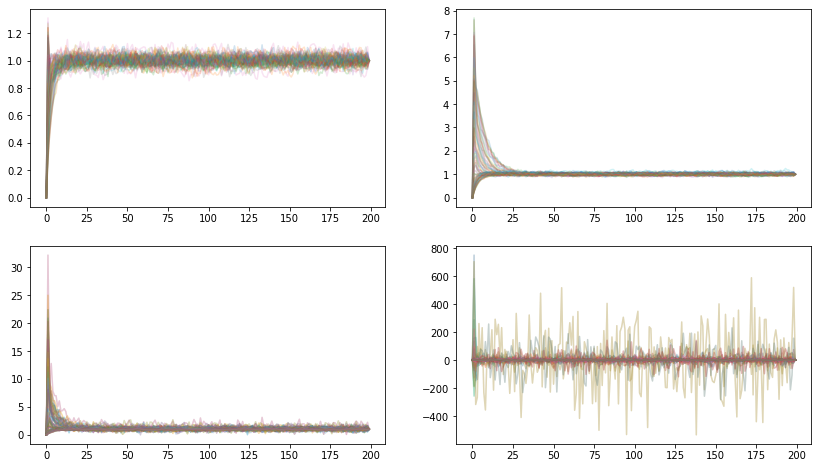

In [21]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
plt.plot(cov_R/cov_R[-1], alpha=0.2);
plt.subplot(2,2,2)
plt.plot(cov_S/cov_S[-1], alpha=0.2);
plt.subplot(2,2,3)
plt.plot(cov_H/cov_H[-1], alpha=0.2);
plt.subplot(2,2,4)
plt.plot(cov_Z/cov_Z[-1], alpha=0.2);

In [22]:
stationari_treshold = 500

In [23]:
results.shape

(37, 6, 2000, 2000)

In [24]:
res = results[...,stationari_treshold::1]
Rx,Ry, Sx, Sy,_,_= res[...,::3].var(axis=2).transpose(1,0,2)
Lx = res[:,0] * res[:,3]
Ly = res[:,1] * res[:,2]

Hx = Lx.mean(axis=1)
Hy = Ly.mean(axis=1)

In [25]:
df["Rx"], df["Rx_err"]= mean_with_err(Rx,axis=-1)
df["Ry"], df["Ry_err"]= mean_with_err(Ry,axis=-1)
df["Sx"], df["Sx_err"]= mean_with_err(Sx,axis=-1)
df["Sy"], df["Sy_err"]= mean_with_err(Sy,axis=-1)
df["Hx"], df["Hx_err"]= mean_with_err(Hx,axis=-1)
df["Hy"], df["Hy_err"]= mean_with_err(Hy,axis=-1)

# df["Rx"], df["Rx_err"]= mean_with_err(Rx,axis=-1)


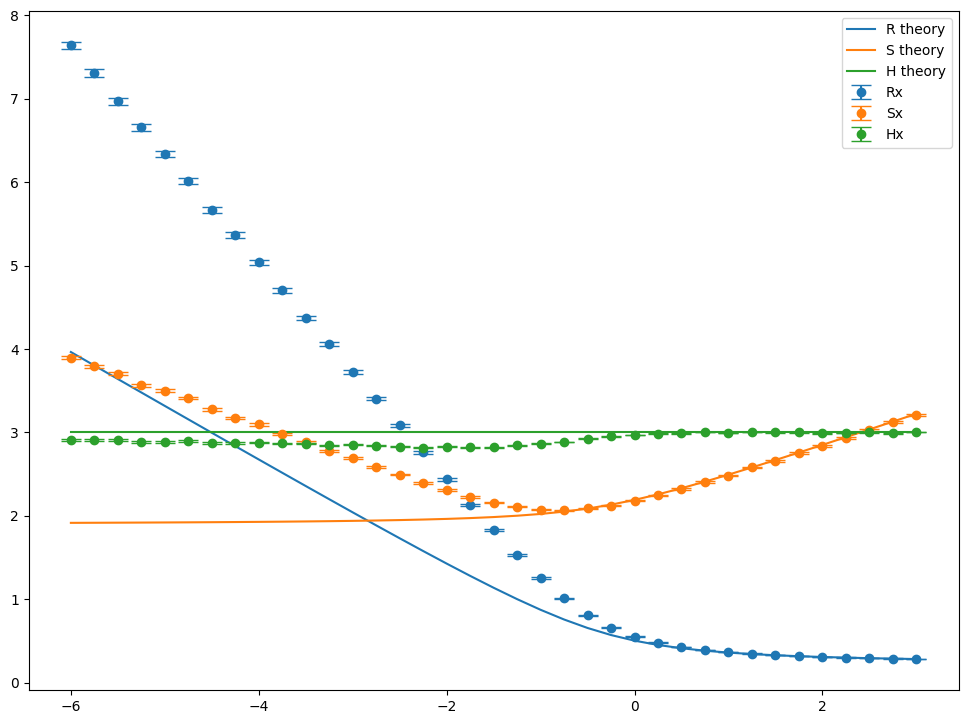

In [26]:
plt.figure(figsize=(12,9), dpi=100)
factor=1

for i,lbl in enumerate(["R","S","H"]):
    NN=df[lbl][len(df)//2+1]
    plt.plot(df.A, df[lbl]/NN+i,label=f"{lbl} theory", c=COLORS[i])
          
    plt.errorbar(df.A, df[lbl+"x"]/NN+i, yerr=df[lbl+"x_err"]*factor, capsize=7, marker="o", ls="none", 
                     label=f"{lbl}x", c=COLORS[i])
plt.legend()
# plt.plot(df.A, df.Rx,df.A, df.Sx,df.A, df.Hx)
# plt.errorbar()

In [58]:
results.shape

(25, 4, 1600, 4000)

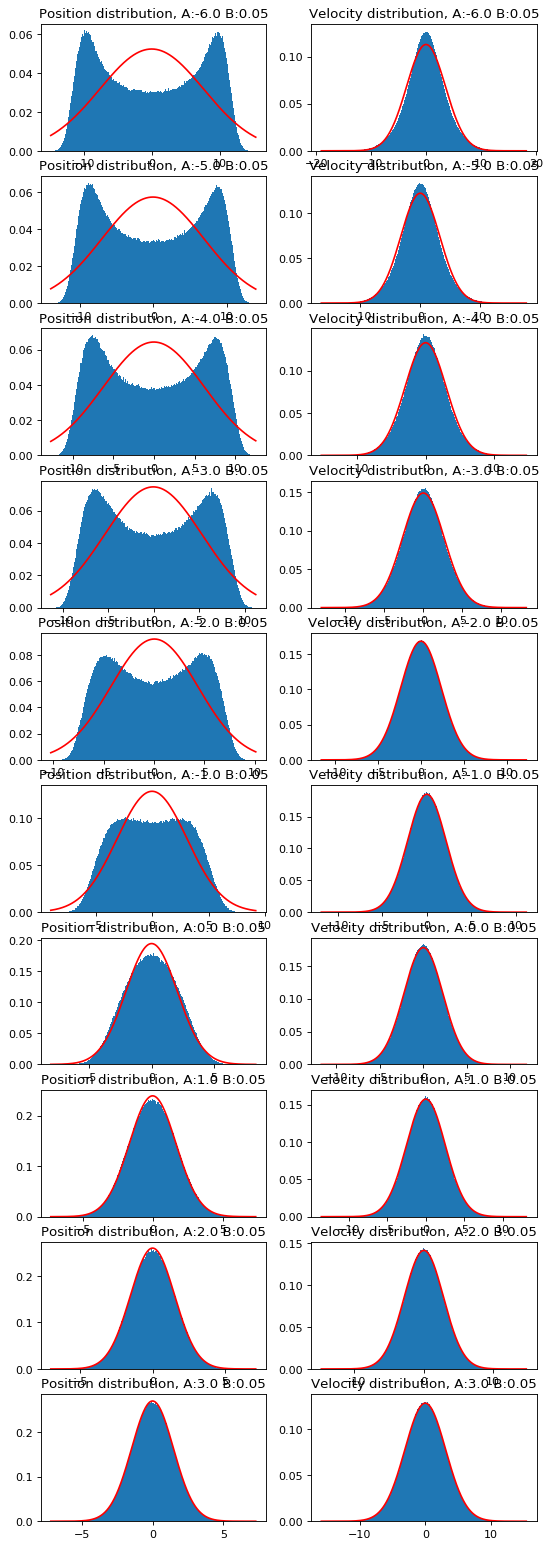

In [25]:
df_small = df.iloc[::4]
plt.figure(figsize=(8,50), dpi=80)
for i,row in enumerate(df_small.itertuples()):
    
    plt.subplot(len(df_small)*2,2,i*2+1)
    values=results[row.Index,0:2,:,2000:].flatten()
    m, s = np.mean(values), np.std(values)
    plt.title(f"Position distribution, A:{row.A:0.1f} B:{row.B:0.2f}")
    _,x,_ = plt.hist(values, bins=1000, density=1);
    plt.plot(x, 1/np.sqrt(2*np.pi)/s*np.exp(-(x-m)**2/2/s/s), c="r")
    
    plt.subplot(len(df_small)*2,2,i*2+2)
    values=results[row.Index,2:4,:,2000:].flatten()
    m, s = np.mean(values), np.std(values)
    plt.title(f"Velocity distribution, A:{row.A:0.1f} B:{row.B:0.2f}")
    _,x,_ = plt.hist(values, bins=1000, density=1);
    plt.plot(x, 1/np.sqrt(2*np.pi)/s*np.exp(-(x-m)**2/2/s/s), c="r")

In [26]:
results.shape

(37, 6, 1600, 4000)

In [42]:
results.shape

(37, 6, 2000, 2000)

Text(0.5, 0, 'A')

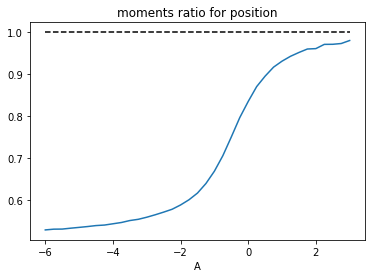

In [46]:
values = results[:,:2,:,stationari_treshold:].reshape(results.shape[0],-1)
moment2 = np.mean(values**2, axis=1)
moment3 = np.mean(values**3, axis=1)
moment4 = np.mean(values**4, axis=1)

plt.plot(df.A,moment4/moment2**2/3)
plt.hlines(y=1, xmin=min(df.A), xmax=max(df.A), ls="--")
plt.title("moments ratio for position")
plt.xlabel("A")

Text(0.5, 0, 'A')

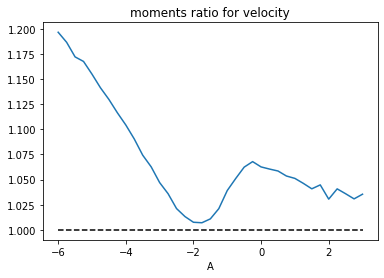

In [45]:
values = results[:,2:4,:,stationari_treshold:].reshape(results.shape[0],-1)
moment2 = np.mean(values**2, axis=1)
moment3 = np.mean(values**3, axis=1)
moment4 = np.mean(values**4, axis=1)

plt.plot(df.A,moment4/moment2**2/3)
plt.hlines(y=1, xmin=min(df.A), xmax=max(df.A), ls="--")
plt.title("moments ratio for velocity")
plt.xlabel("A")

In [37]:
res = results[...,stationari_treshold::]

uxs, uys = [], []
for row in df.itertuples():
    ux, uy = Uxy_2(-row.A, row.B,0,0,0, res[row.Index,0].flatten(),res[row.Index,1].flatten() )
    uxs.append(ux.reshape(res.shape[2], res.shape[3]))
    uys.append(uy.reshape(res.shape[2], res.shape[3]))

uxs=np.array(uxs)
uys=np.array(uys)

xry= res[:,0] * res[:,5]
yrx= res[:,1] * res[:,4]

uxry= uxs*res[:,5]
uyrx= uys*res[:,4]

In [38]:
df["xry"], df["xry_err"]=mean_with_err(xry.reshape(xry.shape[0],-1), axis=1)
df["uxry"], df["uxry_err"]=mean_with_err(uxry.reshape(uxry.shape[0],-1), axis=1)

In [54]:
uxs.shape

(37, 2000, 1250)

<ErrorbarContainer object of 3 artists>

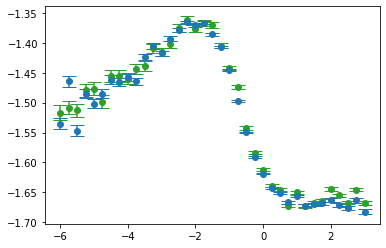

In [39]:
g0kasq=0.3
#     plt.plot(gp.b, gp.Hx)
plt.errorbar(df.A, df.Hx, yerr=df.Hx_err, capsize=7, marker="o",color=COLORS[2], ls="none")
plt.errorbar(df.A, df.H+df.uxry/g0kasq, yerr=df.uxry_err/g0kasq, capsize=7, marker="o",color=COLORS[0], ls="none")

In [ ]:
gb=df.groupby(["A","B","C","D","F"])

plt.figure(figsize=(10,7), dpi=150)
plt.title("H vs b")
plt.xlabel("b");plt.ylabel("H")
plt.plot(bs_expected, H_expected,ls=(0, (5, 10)), label="harmonic (theory)")
for ii, key in enumerate(gb.groups):
    
    gp = gb.get_group(key)
    
    g0kasq=gp.g0.mean() * gp.ka.mean()**2
#     plt.plot(gp.b, gp.Hx)
    plt.errorbar(gp.b, gp.Hx, yerr=gp.Hx_err, capsize=7, marker="o",color=COLORS[ii], ls="none", 
                 label=f"A: {gp.A.mean():0.2f} B: {gp.B.mean():0.2f} C: {gp.C.mean():0.2f}")
    
    plt.errorbar(gp.b+0.1, gp.H + gp.uxry/g0kasq, yerr=gp.uxry_err/g0kasq, capsize=7,color=COLORS[ii], marker="s", mfc="white", ls="none", 
                 label=f"theoretical guess")
# plt.xlim(-1,5)
# plt.ylim(-4,1)
plt.legend()

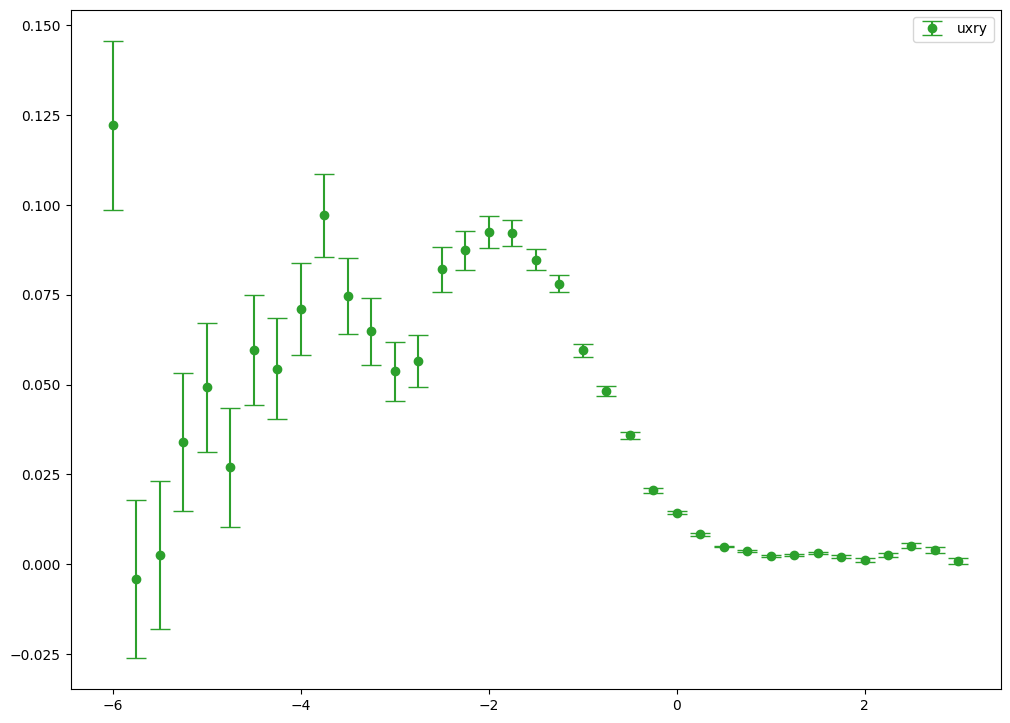

In [56]:
plt.figure(figsize=(12,9), dpi=100)
factor=1

# plt.plot(df.A, df[lbl]/NN+i,label=f"{lbl} theory", c=COLORS[i])

plt.errorbar(df.A, df["uxry"], yerr=df["uxry_err"]*factor, capsize=7, marker="o", ls="none", 
                 label=f"uxry", c=COLORS[i])
plt.legend()
# plt.plot(df.A, df.Rx,df.A, df.Sx,df.A, df.Hx)
# plt.errorbar()

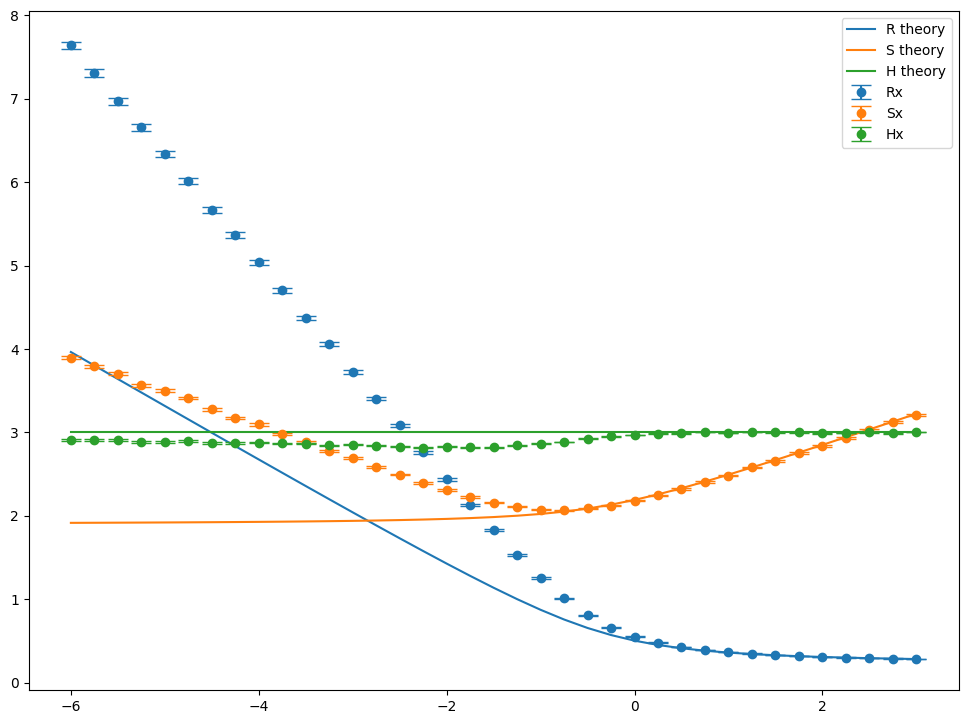

In [29]:
plt.figure(figsize=(12,9), dpi=100)
factor=1

for i,lbl in enumerate(["R","S","H"]):
    NN=df[lbl][len(df)//2+1]
    plt.plot(df.A, df[lbl]/NN+i,label=f"{lbl} theory", c=COLORS[i])
          
    plt.errorbar(df.A, df[lbl+"x"]/NN+i, yerr=df[lbl+"x_err"]*factor, capsize=7, marker="o", ls="none", 
                     label=f"{lbl}x", c=COLORS[i])
plt.legend()
# plt.plot(df.A, df.Rx,df.A, df.Sx,df.A, df.Hx)
# plt.errorbar()